In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# set random seeds for reproducability
seed = 42
np.random.seed(seed=seed)
_ = torch.manual_seed(seed=seed)

In [3]:
# plot settings
plt.style.use('fivethirtyeight')

## Constants and Hyperparameters

In [4]:
epochs = 10
batch_size = 4

hidden_size = 64
learning_rate = 0.0001

## Creating a Syntethic Time-Series Dataset

In [5]:
N = 1000   # number of data points
mu = 0      # mu of normal distribution 
sigma = 0.4   # sigma^2 of normal distribution   
noise = np.random.normal(mu, sigma, size=N) # normal dist. noise

X_sequence = np.sin(np.linspace(0, 30, N)) + noise

print(f'Shape of X_sequence: {X_sequence.shape}')

Shape of X_sequence: (1000,)


#### Plotting the Sequence aginst Time

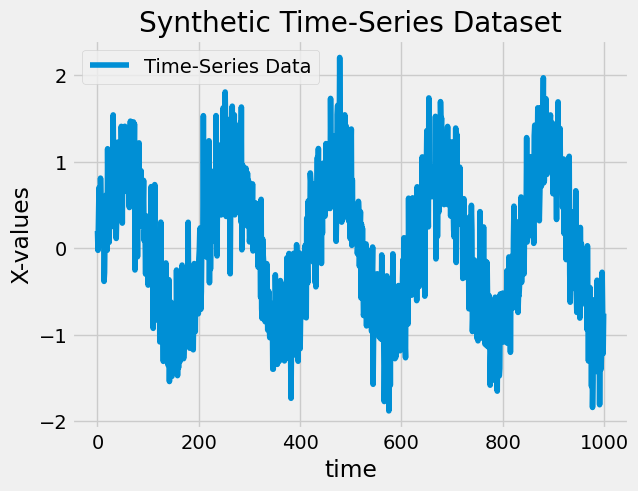

In [6]:
_, ax = plt.subplots(nrows=1, ncols=1)

ax.set_title('Synthetic Time-Series Dataset')
ax.plot(X_sequence, label='Time-Series Data')
ax.set_xlabel('time')
ax.set_ylabel('X-values')
ax.legend()
plt.show()

#### Create Timestamps

In [7]:
seq_len = 16
X_, Y_ = [], []

# pytorch RNN wants input of shape [batch_size, seq_len, num_features]
for i in range(0, N - seq_len):
    X_.append(X_sequence[i:i + seq_len].reshape(seq_len, 1)) # num_features = 1
    Y_.append(X_sequence[i+seq_len])
X = np.stack(X_)
Y = np.stack(Y_).reshape(-1, 1)
print(f'Shape of X: {X.shape}')
print(f'Shape of Y: {Y.shape}')

Shape of X: (984, 16, 1)
Shape of Y: (984, 1)


#### Splitting for Training and Test Set

In [8]:
N = X.shape[0]
train_size = 0.7
N_train = int(train_size * N)
X_train, y_train = X[:N_train], Y[:N_train]
X_test, y_test = X[N_train:], Y[N_train:]

# setting up time axis for plotting
time_train = range(0, len(X_train))
time_test = range(len(X_train), len(X_train) + len(X_test))

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (688, 16, 1)
Shape of y_train: (688, 1)
Shape of X_test: (296, 16, 1)
Shape of y_test: (296, 1)


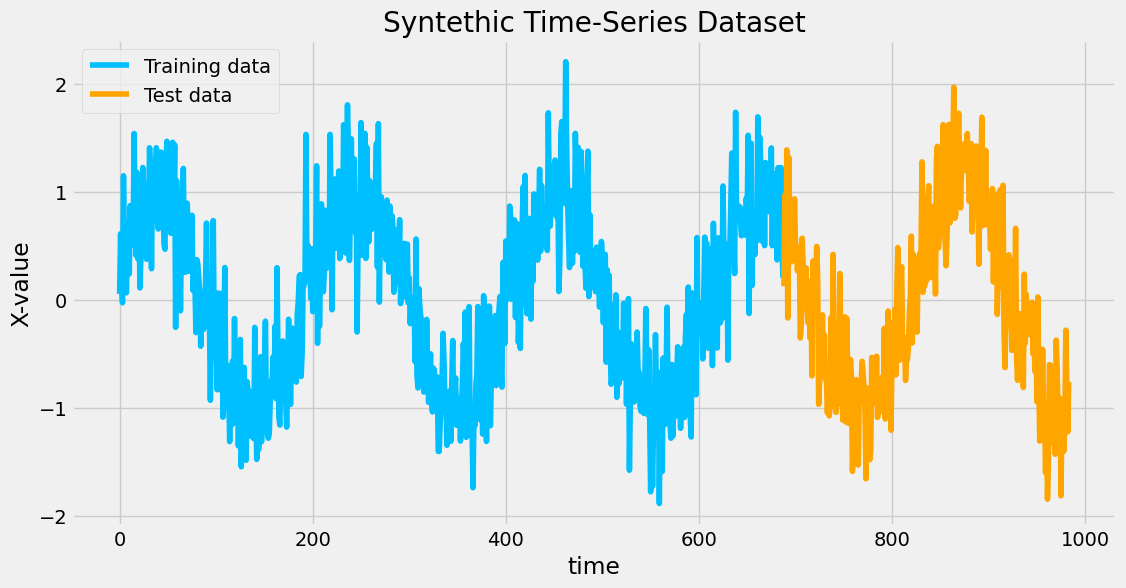

In [9]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.set_title('Syntethic Time-Series Dataset')
ax.plot(time_train, y_train, label='Training data', color='deepskyblue')
ax.plot(time_test, y_test, label='Test data', color='orange')
ax.set_xlabel('time')
ax.set_ylabel('X-value')
ax.legend()
plt.show()

#### Transform NumPy Arrays to PyTorch Tensor Datasets and Load them into a Dataloader

In [10]:
train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

dataloader_train = DataLoader(train_set, shuffle=False, batch_size=batch_size)
dataloader_test = DataLoader(test_set, shuffle=False, batch_size=batch_size)

#### Training and Evaluation

In [11]:
def train(
        model: nn.Module,
        dataloader: DataLoader,
        verbose: bool=False
        ) -> None:

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for input, target in dataloader:
            optimizer.zero_grad()
            pred = model(input)
            loss = criterion(pred, target)
            total_loss += loss.item() * input.size(0)
            loss.backward()
            optimizer.step()
        if verbose:
            total_loss = total_loss / len(dataloader)
            print(f'epoch: {epoch}\tmse: {total_loss}')


def evaluate(
        model: nn.Module,
        dataloader: DataLoader,
    ) -> tuple:
    N = len(dataloader)
    mse = 0.0
    pred_all = []
    target_all = []
    with torch.no_grad():
        for input, target in dataloader:
            pred = model(input)
            pred_all.append(pred) 
            target_all.append(target) 
            loss = torch.sum((target - pred)**2)
            mse += loss.item()
    pred_all = torch.concatenate(pred_all, dim=0)
    target_all = torch.concatenate(target_all, dim=0)
    
    # Evaluate performance 
    pred_mean = torch.mean(pred_all) 
    r2_score = torch.sum((pred_all - pred_mean)**2) / torch.sum((target_all - pred_mean)**2) 
    mse = mse / N
    rmse = (mse**0.5) / N
    return pred_all, mse, rmse, r2_score


# Forecasting

## Basic Recurrent Neural Network

In [12]:
class SimpleRNN(nn.Module):
    """
    1-layer Elman RNN with tanh non-linearity and a hidden layer on top.
    """ 
    
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            output_size: int
            ) -> None:
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, _ = self.rnn(x)              # [N, seq_len, hidden_size]
        x = self.fc(x[:, -1, :])
        return x

In [13]:
input_size = 1
hidden_size = 64
output_size = 1

model = SimpleRNN(input_size, hidden_size, output_size)
train(model, dataloader_train, verbose=True)
preds_train, mse_train, rmse_train, r2_train = evaluate(model, dataloader_train)
preds_test, mse_test, rmse_test, r2_test = evaluate(model, dataloader_test)

y_pred_train = preds_train.numpy()
y_pred_test = preds_test.numpy()

epoch: 0	mse: 2.156338667410404
epoch: 1	mse: 0.8822524906244389
epoch: 2	mse: 0.7856715377474334
epoch: 3	mse: 0.7695670127868652
epoch: 4	mse: 0.7603535753577341
epoch: 5	mse: 0.7545336114545894
epoch: 6	mse: 0.7506112154724813
epoch: 7	mse: 0.7477891049456111
epoch: 8	mse: 0.7456125981217727
epoch: 9	mse: 0.7438151950103252


In [14]:
print(f'Eval (train) - mse: {mse_train}\trmse: {rmse_train}\tr2: {r2_train}')
print(f'Eval (test)  - mse: {mse_test} \trmse: {rmse_test} \tr2: {r2_test}')

Eval (train) - mse: 0.7226618986230257	rmse: 0.004942414122963183	r2: 0.7218655943870544
Eval (test)  - mse: 0.6970199024103381 	rmse: 0.011282124027553844 	r2: 0.7021535634994507


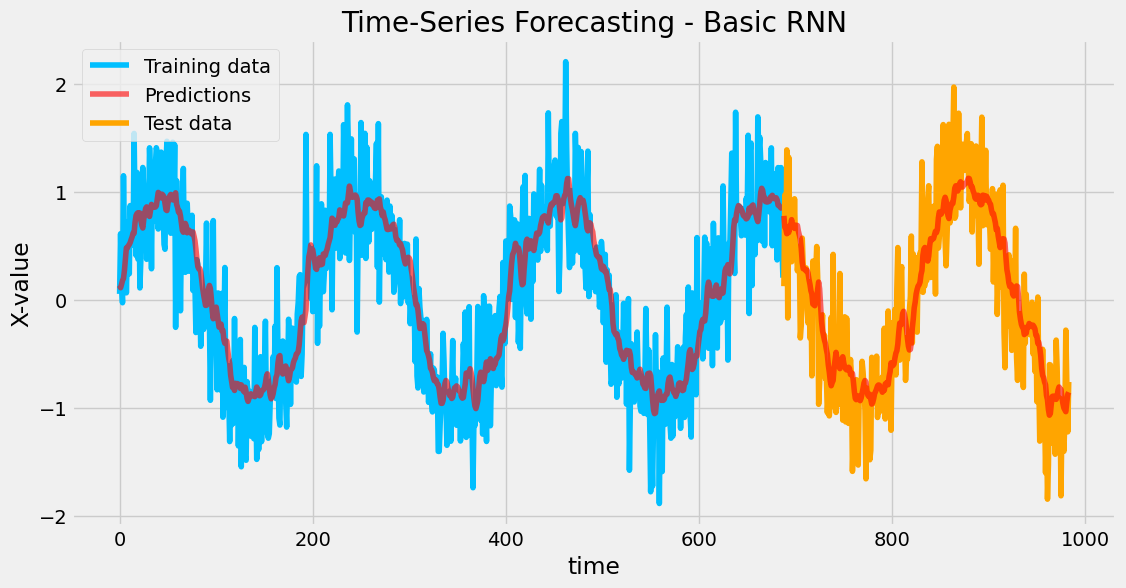

In [15]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.set_title('Time-Series Forecasting - Basic RNN')
ax.plot(time_train, y_train, label='Training data', color='deepskyblue')
ax.plot(time_train, y_pred_train, label='Predictions', color='red', alpha=0.6)

ax.plot(time_test, y_test, label='Test data', color='orange')
ax.plot(time_test, y_pred_test, color='red', alpha=0.6)
ax.set_xlabel('time')
ax.set_ylabel('X-value')
ax.legend()
plt.show()

## Gated Recurrent Unit (GRU) RNN

In [16]:
class SimpleGRU(nn.Module):
    """
    1-layer Elman RNN with tanh non-linearity and a hidden layer on top.
    """ 
    
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            output_size: int
            ) -> None:
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, _ = self.gru(x)              # [N, seq_len, hidden_size]
        x = self.fc(x[:, -1, :])
        return x

In [17]:
input_size = 1
hidden_size = 64
output_size = 1

model = SimpleGRU(input_size, hidden_size, output_size)
train(model, dataloader_train, verbose=True)
preds_train, mse_train, rmse_train, r2_train = evaluate(model, dataloader_train)
preds_test, mse_test, rmse_test, r2_test = evaluate(model, dataloader_test)

y_pred_train = preds_train.numpy()
y_pred_test = preds_test.numpy()

epoch: 0	mse: 2.586046567771497
epoch: 1	mse: 1.8709898536353438
epoch: 2	mse: 0.9084853318974723
epoch: 3	mse: 0.7559957514885206
epoch: 4	mse: 0.7513584811023848
epoch: 5	mse: 0.7485364740172964
epoch: 6	mse: 0.7464370707504798
epoch: 7	mse: 0.7447607726681718
epoch: 8	mse: 0.7433738136923936
epoch: 9	mse: 0.7422025629297592


In [18]:
print(f'Eval (train) - mse: {mse_train}\trmse: {rmse_train}\tr2: {r2_train}')
print(f'Eval (test)  - mse: {mse_test} \trmse: {rmse_test} \tr2: {r2_test}')

Eval (train) - mse: 0.7294748193086233	rmse: 0.004965656863267433	r2: 0.6870368123054504
Eval (test)  - mse: 0.7032307361730853 	rmse: 0.011332277541411598 	r2: 0.6872311234474182


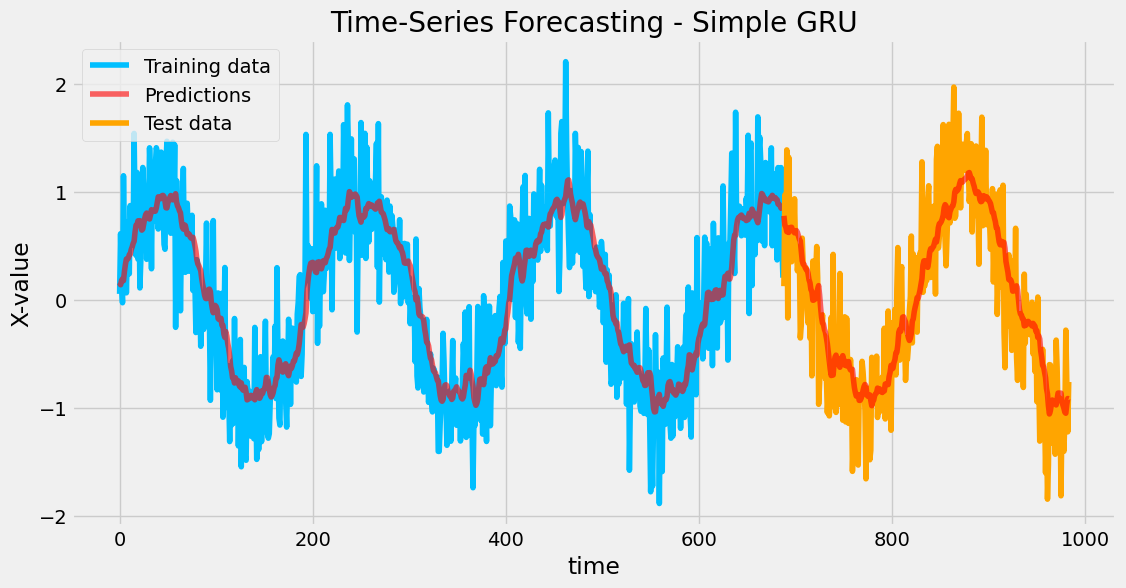

In [19]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.set_title('Time-Series Forecasting - Simple GRU')
ax.plot(time_train, y_train, label='Training data', color='deepskyblue')
ax.plot(time_train, y_pred_train, label='Predictions', color='red', alpha=0.6)

ax.plot(time_test, y_test, label='Test data', color='orange')
ax.plot(time_test, y_pred_test, color='red', alpha=0.6)
ax.set_xlabel('time')
ax.set_ylabel('X-value')
ax.legend()
plt.show()

## Long Short-Term Memory (LSTM)

In [20]:
class SimpleLSTM(nn.Module):
    """
    1-layer Elman RNN with tanh non-linearity and a hidden layer on top.
    """ 
    
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            output_size: int
            ) -> None:
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, _ = self.lstm(x)              # [N, seq_len, hidden_size]
        x = self.fc(x[:, -1, :])
        return x

In [21]:
input_size = 1
hidden_size = 64
output_size = 1

model = SimpleLSTM(input_size, hidden_size, output_size)
train(model, dataloader_train, verbose=True)
preds_train, mse_train, rmse_train, r2_train = evaluate(model, dataloader_train)
preds_test, mse_test, rmse_test, r2_test = evaluate(model, dataloader_test)

y_pred_train = preds_train.numpy()
y_pred_test = preds_test.numpy()

epoch: 0	mse: 2.4446849113460196
epoch: 1	mse: 1.8120419810807635
epoch: 2	mse: 0.8578013078374571
epoch: 3	mse: 0.7923423230409795
epoch: 4	mse: 0.7817536358190917
epoch: 5	mse: 0.7747636354625832
epoch: 6	mse: 0.7693760246958931
epoch: 7	mse: 0.7649418403351202
epoch: 8	mse: 0.7611663592708579
epoch: 9	mse: 0.7578858832319721


In [22]:
print(f'Eval (train) - mse: {mse_train}\trmse: {rmse_train}\tr2: {r2_train}')
print(f'Eval (test)  - mse: {mse_test} \trmse: {rmse_test} \tr2: {r2_test}')

Eval (train) - mse: 0.7363419730519486	rmse: 0.004988975044372648	r2: 0.6615371704101562
Eval (test)  - mse: 0.7269824844457813 	rmse: 0.011522063222970572 	r2: 0.6487107276916504


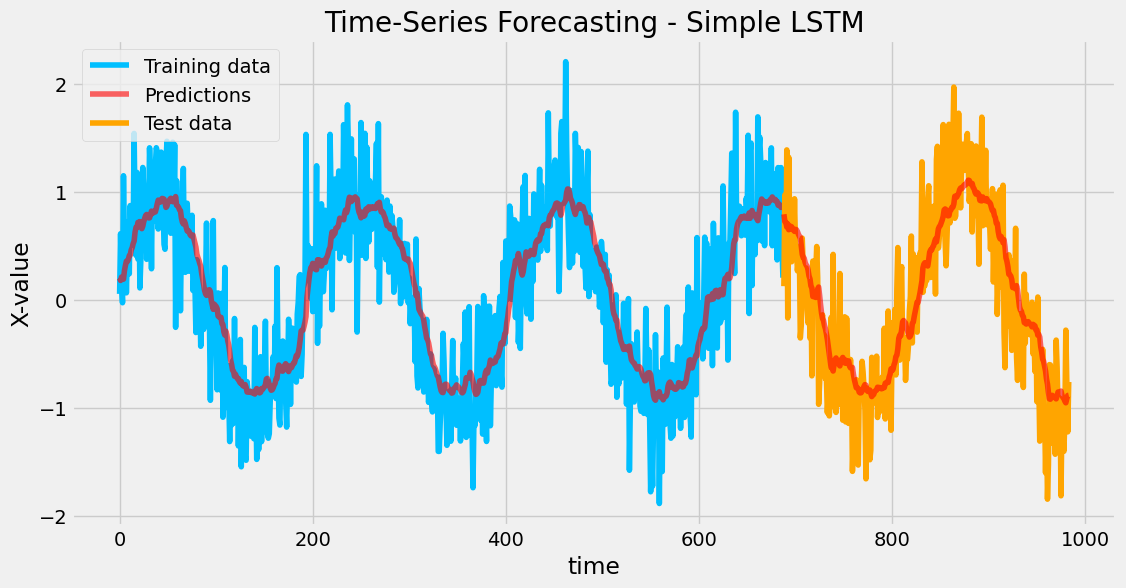

In [23]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.set_title('Time-Series Forecasting - Simple LSTM')
ax.plot(time_train, y_train, label='Training data', color='deepskyblue')
ax.plot(time_train, y_pred_train, label='Predictions', color='red', alpha=0.6)

ax.plot(time_test, y_test, label='Test data', color='orange')
ax.plot(time_test, y_pred_test, color='red', alpha=0.6)
ax.set_xlabel('time')
ax.set_ylabel('X-value')
ax.legend()
plt.show()